In [41]:
import pandas as pd
import numpy as np
import eia
import requests
import json
import yaml
from prophet import Prophet

# Definitions
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
pd.set_option('display.max_columns', 100)    #Display upto 100 columns 
pd.set_option('display.max_rows', 100) 
%matplotlib inline

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')   

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# To be able to pull modules from src folder 
import os
import sys
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

In [3]:
from d00_utils.const import *
from d00_utils.utils import setup_env_vars, load_yml, get_filepath

setup_env_vars()
os.environ.get("EIA_ACCESS_KEY")

2022-03-05 14:19:46,984 - Finding .env file to load entries as environment variables...
2022-03-05 14:19:46,989 - Finished loading environment variables.


'xPWAeqwYEwqmxA0hFnjsCUbcyxEG95ajpq4aX89p'

## Pulling Raw Data (JSON) and Creating Intermediate CSVs
So far, we've pulled all the raw data we're interested in and created intermediate CSVS for it - including handling of failed API requests. 

In [4]:
eia_api_ids = load_yml(EIA_API_IDS_YML_FILEPATH)
for data_type, api_ids_dict in eia_api_ids.items(): 
    print(data_type, api_ids_dict)
    print('\n')

Net_Gen_By_Fuel_MWh {'all_fuels': 'ELEC.GEN.ALL-{}-99.Q', 'coal': 'ELEC.GEN.COW-{}-99.Q', 'natural_gas': 'ELEC.GEN.NG-{}-99.Q', 'nuclear': 'ELEC.GEN.NUC-{}-99.Q', 'hydro': 'ELEC.GEN.HYC-{}-99.Q', 'other_renewables': 'ELEC.GEN.AOR-{}-99.Q', 'wind': 'ELEC.GEN.WND-{}-99.Q', 'solar_utility': 'ELEC.GEN.SUN-{}-99.Q', 'solar_all': 'ELEC.GEN.TSN-{}-99.Q', 'other': 'ELEC.GEN.OTH-{}-99.Q'}


Fuel_Consumption_BTU {'coal': 'ELEC.CONS_TOT_BTU.COW-{}-99.Q', 'natural_gas': 'ELEC.CONS_TOT_BTU.NG-{}-99.Q'}




In [19]:
# Working code so far
from d01_data.get_raw_data import load_all_data
from d02_intermediate.clean_raw_data import clean_all_data
from d03_processing.create_model_input import process_all_data

load_all_data(eia_api_ids)
clean_all_data(eia_api_ids)
process_all_data(eia_api_ids)

2022-03-05 11:55:45,182 - Invalid response for EIA Series ID: elec.gen.wnd-al-99.q with error message: invalid series_id. For key registration, documentation, and examples see https://www.eia.gov/developer/
2022-03-05 11:55:45,304 - Invalid response for EIA Series ID: elec.gen.wnd-ar-99.q with error message: invalid series_id. For key registration, documentation, and examples see https://www.eia.gov/developer/


## Model Training and Forecasting
With all the data cleaned, imputed and engineered to create the processed data which will be fed into the ML models for training, the next step is to create a framework for training and saving the time-series models for each dataset. 

In [57]:
# Sample intermediate files for testing: 
all_fuels = '../data/03_processed/Net_Gen_By_Fuel_MWh/AL/Net_Gen_By_Fuel_MWh-all_fuels.csv'
coal = '../data/03_processed/Net_Gen_By_Fuel_MWh/AL/Net_Gen_By_Fuel_MWh-coal.csv'

df_all_fuels = pd.read_csv(all_fuels)
df_coal = pd.read_csv(coal)
df_all_fuels.head()

,ds,y
0,2001-03-31,30267.126
1,2001-06-30,28933.315
2,2001-09-30,35618.737
3,2001-12-31,30525.935
4,2002-03-31,30347.665


In [58]:
df_coal.columns = ['ds', 'y']
# df_coal['cap'] = df_coal.y.max()
df_coal['floor'] = 0
df_coal.head()

,ds,y,floor
0,2001-03-31,17430.289,0
1,2001-06-30,17043.527,0
2,2001-09-30,20808.621,0
3,2001-12-31,16915.677,0
4,2002-03-31,14804.407,0


In [59]:
m = Prophet(growth='logistic')
m.fit(df_coal)

ValueError: Capacities must be supplied for logistic growth in column "cap"

In [25]:
future = m.make_future_dataframe(periods=24, freq='Q')
future.tail()

,ds
103,2026-12-31
104,2027-03-31
105,2027-06-30
106,2027-09-30
107,2027-12-31


In [54]:
# future['cap'] = df_coal.y.max()
future['floor'] = 0
forecast = m.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast.tail()

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
103,2026-12-31,2357.237,21853.402,0,-497.047,3421.313,2357.237,2357.237,-934.552,-934.552,-934.552,-934.552,-934.552,-934.552,0.000,0.000,0.000,1422.685
104,2027-03-31,2264.398,21853.402,0,-262.719,3496.782,2264.398,2264.398,-598.417,-598.417,-598.417,-598.417,-598.417,-598.417,0.000,0.000,0.000,1665.981
105,2027-06-30,2173.830,21853.402,0,319.310,4151.865,2173.830,2173.830,48.710,48.710,48.710,48.710,48.710,48.710,0.000,0.000,0.000,2222.540
106,2027-09-30,2085.557,21853.402,0,2305.022,6160.350,2085.557,2085.557,2137.572,2137.572,2137.572,2137.572,2137.572,2137.572,0.000,0.000,0.000,4223.128
107,2027-12-31,2000.503,21853.402,0,-1028.111,2825.288,2000.503,2000.503,-1091.882,-1091.882,-1091.882,-1091.882,-1091.882,-1091.882,0.000,0.000,0.000,908.622


In [19]:
forecast['y'] = m.history['y'].combine_first(forecast['yhat'])
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,2001-03-31,5644.495,16425.991,19728.290,5644.495,5644.495,12440.017,12440.017,12440.017,12440.017,12440.017,12440.017,0.000,0.000,0.000,18084.512,17430.289
1,2001-06-30,5595.720,16703.295,20141.191,5595.720,5595.720,12959.626,12959.626,12959.626,12959.626,12959.626,12959.626,0.000,0.000,0.000,18555.346,17043.527
2,2001-09-30,5546.410,19261.031,22920.267,5546.410,5546.410,15554.214,15554.214,15554.214,15554.214,15554.214,15554.214,0.000,0.000,0.000,21100.623,20808.621
3,2001-12-31,5497.099,17177.807,20470.923,5497.099,5497.099,13230.402,13230.402,13230.402,13230.402,13230.402,13230.402,0.000,0.000,0.000,18727.501,16915.677
4,2002-03-31,5448.860,16596.893,20229.821,5448.860,5448.860,12972.509,12972.509,12972.509,12972.509,12972.509,12972.509,0.000,0.000,0.000,18421.369,14804.407


In [60]:
# Test function after adding to script 
from d04_modelling.create_prophet_models import train_all_models
train_all_models(eia_api_ids)

from d06_reporting.create_forecasts import create_all_forecasts
create_all_forecasts(eia_api_ids)

2022-03-05 16:22:19,017 - Training and Saving Prophet Models...
2022-03-05 16:22:19,018 - Training models for State: AL
2022-03-05 16:22:19,019 - Training models for Category: Net_Gen_By_Fuel_MWh
2022-03-05 16:22:19,037 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:19,038 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-03-05 16:22:20,892 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:20,893 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -91.711
Iteration  1. Log joint probability =    99.1621. Improved by 190.873.
Iteration  2. Log joint probability =    101.498. Improved by 2.33624.
Iteration  3. Log joint probability =     175.89. Improved by 74.3915.
Iteration  4. Log joint probability =    175.905. Improved by 0.0156194.
Iteration  5. Log joint probability =    175.981. Improved by 0.0753379.
Iteration  6. Log joint probability =    176.126. Improved by 0.145448.
Iteration  7. Log joint probability =    210.444. Improved by 34.3179.
Iteration  8. Log joint probability =     226.27. Improved by 15.8253.
Iteration  9. Log joint probability =    226.385. Improved by 0.114964.
Iteration 10. Log joint probability =     226.41. Improved by 0.0253536.
Iteration 11. Log joint probability =    226.939. Improved by 0.529448.
Iteration 12. Log joint probability =    227.249. Improved by 0.309778.
Iteration 13. Log joint probability =    238.459. Improved by 11.2101.
Iteration 14. Log joint pr

2022-03-05 16:22:22,408 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:22,409 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -92.1797
Iteration  1. Log joint probability =    68.6238. Improved by 160.803.
Iteration  2. Log joint probability =    127.623. Improved by 58.9992.
Iteration  3. Log joint probability =    127.625. Improved by 0.00178294.
Iteration  4. Log joint probability =    127.662. Improved by 0.0367992.
Iteration  5. Log joint probability =    127.704. Improved by 0.0421381.
Iteration  6. Log joint probability =    155.338. Improved by 27.6338.
Iteration  7. Log joint probability =    155.422. Improved by 0.0843067.
Iteration  8. Log joint probability =    155.726. Improved by 0.303883.
Iteration  9. Log joint probability =    155.848. Improved by 0.122752.
Iteration 10. Log joint probability =    155.965. Improved by 0.116853.
Iteration 11. Log joint probability =    156.014. Improved by 0.0488764.
Iteration 12. Log joint probability =     156.02. Improved by 0.00598548.
Iteration 13. Log joint probability =    156.117. Improved by 0.0971122.
Iteration 14. Lo

2022-03-05 16:22:23,748 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:23,749 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -92.5367
Iteration  1. Log joint probability =    18.6407. Improved by 111.177.
Iteration  2. Log joint probability =    135.649. Improved by 117.009.
Iteration  3. Log joint probability =    135.669. Improved by 0.0194406.
Iteration  4. Log joint probability =    135.721. Improved by 0.0526387.
Iteration  5. Log joint probability =    144.891. Improved by 9.16982.
Iteration  6. Log joint probability =    144.972. Improved by 0.0805249.
Iteration  7. Log joint probability =    145.018. Improved by 0.0467628.
Iteration  8. Log joint probability =    145.042. Improved by 0.0233684.
Iteration  9. Log joint probability =    145.154. Improved by 0.112062.
Iteration 10. Log joint probability =     145.21. Improved by 0.0559239.
Iteration 11. Log joint probability =    145.218. Improved by 0.00835207.
Iteration 12. Log joint probability =     145.28. Improved by 0.062084.
Iteration 13. Log joint probability =    146.924. Improved by 1.64369.
Iteration 14. Log 

2022-03-05 16:22:24,515 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:24,516 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -91.5674
Iteration  1. Log joint probability =    103.691. Improved by 195.258.
Iteration  2. Log joint probability =    157.934. Improved by 54.2437.
Iteration  3. Log joint probability =    196.584. Improved by 38.6493.
Iteration  4. Log joint probability =    206.309. Improved by 9.72563.
Iteration  5. Log joint probability =    206.812. Improved by 0.503133.
Iteration  6. Log joint probability =    206.823. Improved by 0.0111355.
Iteration  7. Log joint probability =    206.827. Improved by 0.00397137.
Iteration  8. Log joint probability =    207.409. Improved by 0.581356.
Iteration  9. Log joint probability =    207.413. Improved by 0.00405387.
Iteration 10. Log joint probability =    207.425. Improved by 0.0124224.
Iteration 11. Log joint probability =    207.505. Improved by 0.0800384.
Iteration 12. Log joint probability =    207.528. Improved by 0.0228173.
Iteration 13. Log joint probability =    207.656. Improved by 0.12795.
Iteration 14. Log j

2022-03-05 16:22:26,100 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:26,101 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-03-05 16:22:26,155 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:26,156 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -93.5674
Iteration  1. Log joint probability =    27.3181. Improved by 120.885.
Iteration  2. Log joint probability =    97.4701. Improved by 70.152.
Iteration  3. Log joint probability =    109.087. Improved by 11.6172.
Iteration  4. Log joint probability =    109.232. Improved by 0.144508.
Iteration  5. Log joint probability =    109.297. Improved by 0.0655864.
Iteration  6. Log joint probability =    109.388. Improved by 0.0910727.
Iteration  7. Log joint probability =    109.467. Improved by 0.0781213.
Iteration  8. Log joint probability =     109.51. Improved by 0.0438928.
Iteration  9. Log joint probability =    109.591. Improved by 0.0803406.
Iteration 10. Log joint probability =      109.6. Improved by 0.00886032.
Iteration 11. Log joint probability =    109.678. Improved by 0.0785618.
Iteration 12. Log joint probability =    109.698. Improved by 0.0201775.
Iteration 13. Log joint probability =    109.924. Improved by 0.225569.
Iteration 14. Log

2022-03-05 16:22:27,340 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:27,341 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -91.8487
Iteration  1. Log joint probability =    76.2393. Improved by 168.088.
Iteration  2. Log joint probability =    83.6758. Improved by 7.43649.
Iteration  3. Log joint probability =    125.452. Improved by 41.7765.
Iteration  4. Log joint probability =    135.749. Improved by 10.297.
Iteration  5. Log joint probability =    135.801. Improved by 0.0519428.
Iteration  6. Log joint probability =    135.875. Improved by 0.0736323.
Iteration  7. Log joint probability =    135.986. Improved by 0.111485.
Iteration  8. Log joint probability =        136. Improved by 0.0137108.
Iteration  9. Log joint probability =    136.127. Improved by 0.126729.
Iteration 10. Log joint probability =    136.162. Improved by 0.0349406.
Iteration 11. Log joint probability =    136.264. Improved by 0.102284.
Iteration 12. Log joint probability =    136.452. Improved by 0.187831.
Iteration 13. Log joint probability =     136.46. Improved by 0.0084022.
Iteration 14. Log join

2022-03-05 16:22:28,386 - Finished models for State: AL
2022-03-05 16:22:28,386 - Training models for State: AR
2022-03-05 16:22:28,387 - Training models for Category: Net_Gen_By_Fuel_MWh
2022-03-05 16:22:28,404 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:28,405 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -91.8073
Iteration  1. Log joint probability =    97.2034. Improved by 189.011.
Iteration  2. Log joint probability =    147.654. Improved by 50.4509.
Iteration  3. Log joint probability =    172.411. Improved by 24.7563.
Iteration  4. Log joint probability =    175.734. Improved by 3.32315.
Iteration  5. Log joint probability =    175.765. Improved by 0.0310564.
Iteration  6. Log joint probability =     175.91. Improved by 0.14527.
Iteration  7. Log joint probability =    179.819. Improved by 3.90894.
Iteration  8. Log joint probability =    180.208. Improved by 0.389482.
Iteration  9. Log joint probability =    181.663. Improved by 1.45439.
Iteration 10. Log joint probability =    183.206. Improved by 1.54273.
Iteration 11. Log joint probability =     184.24. Improved by 1.03411.
Iteration 12. Log joint probability =    185.235. Improved by 0.994881.
Iteration 13. Log joint probability =     185.64. Improved by 0.405329.
Iteration 14. Log joint probab

2022-03-05 16:22:29,930 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:29,932 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -92.3265
Iteration  1. Log joint probability =    75.1797. Improved by 167.506.
Iteration  2. Log joint probability =    126.832. Improved by 51.652.
Iteration  3. Log joint probability =    129.268. Improved by 2.43609.
Iteration  4. Log joint probability =    143.459. Improved by 14.1914.
Iteration  5. Log joint probability =    143.521. Improved by 0.0621245.
Iteration  6. Log joint probability =    144.193. Improved by 0.67114.
Iteration  7. Log joint probability =    144.211. Improved by 0.0180227.
Iteration  8. Log joint probability =    144.538. Improved by 0.327334.
Iteration  9. Log joint probability =    144.735. Improved by 0.197393.
Iteration 10. Log joint probability =    145.159. Improved by 0.424099.
Iteration 11. Log joint probability =    146.334. Improved by 1.1742.
Iteration 12. Log joint probability =    146.654. Improved by 0.320088.
Iteration 13. Log joint probability =    147.084. Improved by 0.429863.
Iteration 14. Log joint prob

2022-03-05 16:22:31,502 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:31,503 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -94.1349
Iteration  1. Log joint probability =    60.2138. Improved by 154.349.
Iteration  2. Log joint probability =    109.813. Improved by 49.5989.
Iteration  3. Log joint probability =    117.181. Improved by 7.36864.
Iteration  4. Log joint probability =    125.378. Improved by 8.19684.
Iteration  5. Log joint probability =    125.385. Improved by 0.0066755.
Iteration  6. Log joint probability =     125.47. Improved by 0.0846756.
Iteration  7. Log joint probability =    125.523. Improved by 0.0536644.
Iteration  8. Log joint probability =    125.592. Improved by 0.0691278.
Iteration  9. Log joint probability =    125.693. Improved by 0.100872.
Iteration 10. Log joint probability =    125.748. Improved by 0.0549878.
Iteration 11. Log joint probability =    133.802. Improved by 8.05422.
Iteration 12. Log joint probability =    133.822. Improved by 0.019092.
Iteration 13. Log joint probability =    133.877. Improved by 0.0553425.
Iteration 14. Log joi

2022-03-05 16:22:32,053 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:32,054 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -92.3683
Iteration  1. Log joint probability =    77.7869. Improved by 170.155.
Iteration  2. Log joint probability =    124.105. Improved by 46.3179.
Iteration  3. Log joint probability =    146.656. Improved by 22.5516.
Iteration  4. Log joint probability =    147.623. Improved by 0.966704.
Iteration  5. Log joint probability =    147.687. Improved by 0.063508.
Iteration  6. Log joint probability =     147.72. Improved by 0.0337562.
Iteration  7. Log joint probability =    147.761. Improved by 0.0402941.
Iteration  8. Log joint probability =    147.799. Improved by 0.037986.
Iteration  9. Log joint probability =    147.814. Improved by 0.0158128.
Iteration 10. Log joint probability =    147.822. Improved by 0.00757772.
Iteration 11. Log joint probability =    147.833. Improved by 0.0105741.
Iteration 12. Log joint probability =    147.839. Improved by 0.00631409.
Iteration 13. Log joint probability =    147.841. Improved by 0.00235699.
Iteration 14. L

2022-03-05 16:22:32,890 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:32,891 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -93.1329
Iteration  1. Log joint probability =    64.0186. Improved by 157.152.
Iteration  2. Log joint probability =    113.624. Improved by 49.6058.
Iteration  3. Log joint probability =    126.833. Improved by 13.2088.
Iteration  4. Log joint probability =    129.187. Improved by 2.35354.
Iteration  5. Log joint probability =     130.14. Improved by 0.953424.
Iteration  6. Log joint probability =    130.302. Improved by 0.16208.
Iteration  7. Log joint probability =    130.526. Improved by 0.223741.
Iteration  8. Log joint probability =    130.609. Improved by 0.0832065.
Iteration  9. Log joint probability =    130.711. Improved by 0.101383.
Iteration 10. Log joint probability =    130.746. Improved by 0.0356341.
Iteration 11. Log joint probability =    130.855. Improved by 0.108598.
Iteration 12. Log joint probability =    130.867. Improved by 0.012314.
Iteration 13. Log joint probability =    130.886. Improved by 0.0187906.
Iteration 14. Log joint 

2022-03-05 16:22:33,548 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:33,549 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-03-05 16:22:33,617 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:33,618 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -93.4448
Iteration  1. Log joint probability =    67.3213. Improved by 160.766.
Iteration  2. Log joint probability =    100.418. Improved by 33.0969.
Iteration  3. Log joint probability =    102.934. Improved by 2.51608.
Iteration  4. Log joint probability =    103.385. Improved by 0.450457.
Iteration  5. Log joint probability =    103.388. Improved by 0.00344516.
Iteration  6. Log joint probability =    103.391. Improved by 0.00308921.
Iteration  7. Log joint probability =    103.429. Improved by 0.0381354.
Iteration  8. Log joint probability =    103.446. Improved by 0.0165276.
Iteration  9. Log joint probability =    103.455. Improved by 0.00898272.
Iteration 10. Log joint probability =    103.459. Improved by 0.00366034.
Iteration 11. Log joint probability =    103.461. Improved by 0.00267615.
Iteration 12. Log joint probability =    103.462. Improved by 0.00026251.
Iteration 13. Log joint probability =    103.464. Improved by 0.00261448.
Iteration

2022-03-05 16:22:34,703 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:34,704 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -94.9443
Iteration  1. Log joint probability =    50.5296. Improved by 145.474.
Iteration  2. Log joint probability =    97.9595. Improved by 47.43.
Iteration  3. Log joint probability =     112.39. Improved by 14.4306.
Iteration  4. Log joint probability =    112.919. Improved by 0.528539.
Iteration  5. Log joint probability =    112.964. Improved by 0.0448837.
Iteration  6. Log joint probability =    112.973. Improved by 0.00917703.
Iteration  7. Log joint probability =    113.004. Improved by 0.0310478.
Iteration  8. Log joint probability =    113.018. Improved by 0.0141098.
Iteration  9. Log joint probability =    113.033. Improved by 0.0154012.
Iteration 10. Log joint probability =    113.059. Improved by 0.0259034.
Iteration 11. Log joint probability =    122.896. Improved by 9.83669.
Iteration 12. Log joint probability =        123. Improved by 0.104564.
Iteration 13. Log joint probability =    123.035. Improved by 0.034874.
Iteration 14. Log joi

2022-03-05 16:22:36,688 - Finished models for State: AR
2022-03-05 16:22:36,689 - Training models for State: AL
2022-03-05 16:22:36,690 - Training models for Category: Fuel_Consumption_BTU
2022-03-05 16:22:36,709 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:36,710 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -92.4891
Iteration  1. Log joint probability =    72.7067. Improved by 165.196.
Iteration  2. Log joint probability =    118.793. Improved by 46.0858.
Iteration  3. Log joint probability =    154.128. Improved by 35.3355.
Iteration  4. Log joint probability =    171.227. Improved by 17.0994.
Iteration  5. Log joint probability =    171.616. Improved by 0.38824.
Iteration  6. Log joint probability =    171.632. Improved by 0.0161409.
Iteration  7. Log joint probability =    171.646. Improved by 0.0139094.
Iteration  8. Log joint probability =    171.748. Improved by 0.10263.
Iteration  9. Log joint probability =    171.775. Improved by 0.0269528.
Iteration 10. Log joint probability =    172.236. Improved by 0.460712.
Iteration 11. Log joint probability =     172.58. Improved by 0.344268.
Iteration 12. Log joint probability =    173.084. Improved by 0.503724.
Iteration 13. Log joint probability =    173.312. Improved by 0.227668.
Iteration 14. Log joint p

2022-03-05 16:22:38,388 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:38,389 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -92.089
Iteration  1. Log joint probability =    84.2325. Improved by 176.321.
Iteration  2. Log joint probability =    100.888. Improved by 16.6552.
Iteration  3. Log joint probability =    100.891. Improved by 0.00310573.
Iteration  4. Log joint probability =    100.935. Improved by 0.0445928.
Iteration  5. Log joint probability =    100.997. Improved by 0.0614797.
Iteration  6. Log joint probability =    101.007. Improved by 0.0102109.
Iteration  7. Log joint probability =    101.016. Improved by 0.0093516.
Iteration  8. Log joint probability =    101.308. Improved by 0.291585.
Iteration  9. Log joint probability =    101.865. Improved by 0.556568.
Iteration 10. Log joint probability =    101.966. Improved by 0.10122.
Iteration 11. Log joint probability =    102.113. Improved by 0.147492.
Iteration 12. Log joint probability =    103.028. Improved by 0.914487.
Iteration 13. Log joint probability =    103.574. Improved by 0.545779.
Iteration 14. Log jo

2022-03-05 16:22:39,811 - Finished models for State: AL
2022-03-05 16:22:39,812 - Training models for State: AR
2022-03-05 16:22:39,812 - Training models for Category: Fuel_Consumption_BTU
2022-03-05 16:22:39,830 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:39,831 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -92.2047
Iteration  1. Log joint probability =    72.7646. Improved by 164.969.
Iteration  2. Log joint probability =    124.694. Improved by 51.929.
Iteration  3. Log joint probability =    124.703. Improved by 0.00926676.
Iteration  4. Log joint probability =    124.719. Improved by 0.0161297.
Iteration  5. Log joint probability =    124.741. Improved by 0.0222843.
Iteration  6. Log joint probability =     128.67. Improved by 3.92895.
Iteration  7. Log joint probability =    128.705. Improved by 0.0351395.
Iteration  8. Log joint probability =    128.712. Improved by 0.00706367.
Iteration  9. Log joint probability =    128.801. Improved by 0.088397.
Iteration 10. Log joint probability =    129.043. Improved by 0.242232.
Iteration 11. Log joint probability =    129.129. Improved by 0.0858131.
Iteration 12. Log joint probability =     129.25. Improved by 0.121472.
Iteration 13. Log joint probability =    129.452. Improved by 0.201255.
Iteration 14. Log 

2022-03-05 16:22:41,167 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 16:22:41,168 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -94.0497
Iteration  1. Log joint probability =    60.2484. Improved by 154.298.
Iteration  2. Log joint probability =    111.737. Improved by 51.4884.
Iteration  3. Log joint probability =    136.914. Improved by 25.1774.
Iteration  4. Log joint probability =    139.261. Improved by 2.34644.
Iteration  5. Log joint probability =    139.277. Improved by 0.0162344.
Iteration  6. Log joint probability =    139.297. Improved by 0.020205.
Iteration  7. Log joint probability =    139.367. Improved by 0.0695441.
Iteration  8. Log joint probability =    139.441. Improved by 0.0747506.
Iteration  9. Log joint probability =    139.515. Improved by 0.0740986.
Iteration 10. Log joint probability =    139.532. Improved by 0.0160869.
Iteration 11. Log joint probability =    139.552. Improved by 0.0206113.
Iteration 12. Log joint probability =    139.567. Improved by 0.0146565.
Iteration 13. Log joint probability =    139.674. Improved by 0.106728.
Iteration 14. Log j

2022-03-05 16:22:42,055 - Finished models for State: AR
2022-03-05 16:22:42,056 - Finished training Prophet models.
2022-03-05 16:22:42,056 - Creating forecasts for all Prophet Models...
2022-03-05 16:22:42,057 - Forecasting for State: AL



Initial log joint probability = -92.2794
Iteration  1. Log joint probability =     77.819. Improved by 170.098.
Iteration  2. Log joint probability =    87.9336. Improved by 10.1146.
Iteration  3. Log joint probability =    128.564. Improved by 40.6307.
Iteration  4. Log joint probability =    134.965. Improved by 6.40027.
Iteration  5. Log joint probability =    152.731. Improved by 17.7663.
Iteration  6. Log joint probability =    152.815. Improved by 0.0843668.
Iteration  7. Log joint probability =    152.978. Improved by 0.162601.
Iteration  8. Log joint probability =    153.049. Improved by 0.0707473.
Iteration  9. Log joint probability =    153.087. Improved by 0.0384853.
Iteration 10. Log joint probability =    153.182. Improved by 0.0953313.
Iteration 11. Log joint probability =    153.261. Improved by 0.0789262.
Iteration 12. Log joint probability =    153.644. Improved by 0.383019.
Iteration 13. Log joint probability =    153.648. Improved by 0.00389404.
Iteration 14. Log jo

2022-03-05 16:22:57,661 - Finished individual forecasting for Net_Gen_By_Fuel_MWh
2022-03-05 16:22:57,662 - Combining individual forecasts for Net_Gen_By_Fuel_MWh
2022-03-05 16:22:57,696 - Completed forecasting for State: AL
2022-03-05 16:22:57,697 - Forecasting for State: AR
2022-03-05 16:23:12,800 - Finished individual forecasting for Net_Gen_By_Fuel_MWh
2022-03-05 16:23:12,801 - Combining individual forecasts for Net_Gen_By_Fuel_MWh
2022-03-05 16:23:12,837 - Completed forecasting for State: AR
2022-03-05 16:23:12,838 - Forecasting for State: AL
2022-03-05 16:23:16,562 - Finished individual forecasting for Fuel_Consumption_BTU
2022-03-05 16:23:16,563 - Combining individual forecasts for Fuel_Consumption_BTU
2022-03-05 16:23:16,575 - Completed forecasting for State: AL
2022-03-05 16:23:16,575 - Forecasting for State: AR
2022-03-05 16:23:20,374 - Finished individual forecasting for Fuel_Consumption_BTU
2022-03-05 16:23:20,375 - Combining individual forecasts for Fuel_Consumption_BTU
20

# Plotting Forecasts 

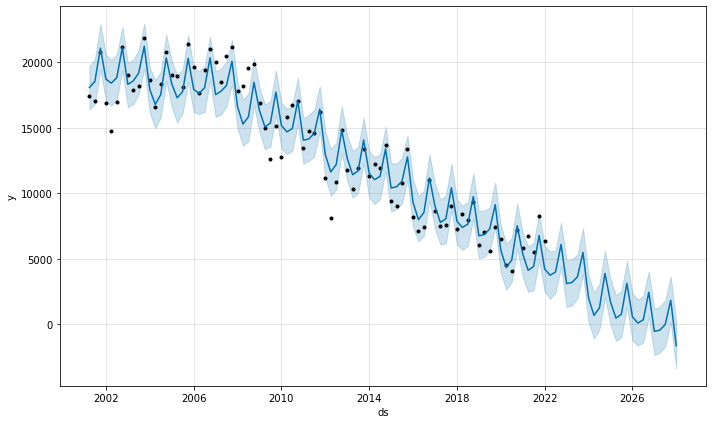

In [27]:
fig1 = m.plot(forecast, plot_cap=True, uncertainty=True)

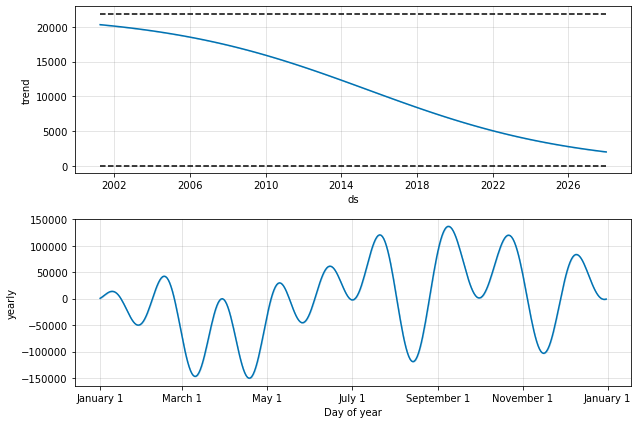

In [56]:
fig2 = m.plot_components(forecast)